# Credit Sesame Takehome Assignment
Finding the default probability of clients. For more information on this dataset, here is the [link](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#) to it.

In [1]:
import pandas as pd
import numpy as np

import os

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

## Settings

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

pd.set_option('display.max_columns', None)

## Parameters

In [3]:
SEED = 1234

TARGET = 'default_payment_next_month'
CLS_WEIGHT ={0:1,1:(1-.22)/.22}
FOLDS = 5

## Setting the directory and loading the data

In [4]:
directory = os.path.dirname(os.path.realpath("__file__"))
print(directory)

C:\Users\Felix Trepanier\Desktop\Job Search 2021\Credit Sesame Data Scientist ML\Credit_Assignment


In [5]:
df = pd.read_excel(directory+"\Data\default of credit card clients.xls", header = 1, index_col = 0)
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Initial data cleaning and data exploration
#### Renaming columns function

In [6]:
def fix_col_names(pd_df: pd.DataFrame)->pd.DataFrame:
    """Takes a dataframe and replaces spaces with underscores in column names. Puts column name in lowercase."""
    pd_df.columns = pd_df.columns.str.replace(' ', '_').str.lower()
    return pd_df


df = fix_col_names(df)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')

#### High level look at all columns

In [7]:
print(df.isnull().sum())
df.describe()

limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64


,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


A few interesting things to note.
1. There does not seem to be any missing values.
2. default_payment_next_month has a mean of 0.2212, meaning that ~ 22% of customers in this dataset have defaulted in the next month. This is not super imbalanced, but should still be kept in mind once we are modelling.
3. Education has a max of 6, but the data dictionary says there should only be 4 categories.
4. Similarly, marriage has a minimum of 0, but the data dictionary says values should range between 1 and 3.
5. Limit_bal has numbers rounded to the 10,000.
6. The pay variables are ranging from -2 to 8, but the data dictionary says values should range between -1 and 9.
7. All the variables in NT dollars likely are right tailed.

In [8]:
def high_level_stats_cat(pd_df: pd.DataFrame, colname: list)->pd.DataFrame:
    """Takes in a dataframe and a variable and returns the count, the proportion, and the default rate for each level"""
    final_df = pd_df.groupby(colname, as_index=False).agg(
        count = ('default_payment_next_month', 'count'),
        proportion = ('default_payment_next_month', 'count'),
        default_rate = ('default_payment_next_month', 'mean')
        )
    final_df = final_df.assign(
        proportion = final_df['proportion']/pd_df.shape[0])
    
    return final_df

#### Looking at the sex variable
From the data dictionary: Gender (1 = male; 2 = female).

Men seem to have a slightly higher default rate than women (~24% to ~21%).
The dataset has 60% women.

In [9]:
high_level_stats_cat(df, ['sex'])

,sex,count,proportion,default_rate
0,1,11888,0.396267,0.241672
1,2,18112,0.603733,0.207763


#### Looking at education
From the data dictionary: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

Interestingly, it seems like more education leads to a lower chance of defaulting since the default rate of clients who went to grad school is lower than clients who went to university and high school.

As pointed out earlier, we have levels that have no definitions in the data dictionary (namely 0, 5, 6). There's a few ways we can treat this:
1. Leave it as is since the levels could be representing other types of education not spelled out in the dictionary.
2. Combine all 3 levels into one.
3. Add all 3 levels to the "other" level (4) since this level is supposed to be the catch all level (not 1, 2, or 3).

Since there are 3 extra levels, I am leaning towards solution 2, which is to combine all 3 levels into level 4. If education shows itself to be a good predictive feature, we can come back and revisit this decision.

In [10]:
high_level_stats_cat(df, ['education'])

,education,count,proportion,default_rate
0,0,14,0.000467,0.000000
1,1,10585,0.352833,0.192348
2,2,14030,0.467667,0.237349
3,3,4917,0.163900,0.251576
4,4,123,0.004100,0.056911
5,5,280,0.009333,0.064286
6,6,51,0.001700,0.156863


#### Looking at marriage
From the data dictionary: Marital status (1 = married; 2 = single; 3 = others).

Interesting to see that there is a "0" level since it is not defined in the data dictionary. One potential explanation for the presence of "0" could be that the field marriage was left blank when the data was gathered. Since there could be a specific reason why the field would be left blank, I can justify leaving it as its own category and not changing all "0" to "3".

In [11]:
high_level_stats_cat(df, ['marriage'])

,marriage,count,proportion,default_rate
0,0,54,0.001800,0.092593
1,1,13659,0.455300,0.234717
2,2,15964,0.532133,0.209283
3,3,323,0.010767,0.260062


#### Looking at limit_bal
From the data dictionary: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

The 4 most frequent specific credit balance limits are bellow 100,000 NT dollars while the majority of customers have a limit greater than 100,000 NT dollars. Since the distribution is right-tailed, it will make sense to transform the variable (using log10) to have a distribution closer to a normal distribution for modelling.

In [12]:
high_level_stats_cat(df, ['limit_bal']).sort_values('count', ascending=False)

,limit_bal,count,proportion,default_rate
5,50000,3365,0.112167,0.263001
2,20000,1976,0.065867,0.353239
3,30000,1610,0.053667,0.352795
8,80000,1567,0.052233,0.231653
20,200000,1528,0.050933,0.176702
...,...,...,...,...
79,800000,2,0.000067,0.000000
70,690000,1,0.000033,0.000000
33,327680,1,0.000033,1.000000
77,760000,1,0.000033,0.000000


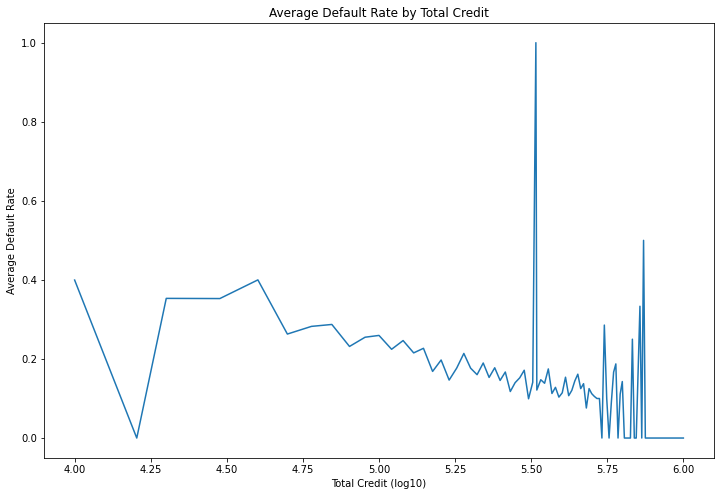

In [14]:
df_limit_bal = pd.DataFrame(high_level_stats_cat(df, ['limit_bal']).sort_values('limit_bal', ascending=False))

plt.plot(np.log10(df_limit_bal['limit_bal']),df_limit_bal['default_rate'])
plt.xlabel('Total Credit (log10)')
plt.ylabel('Average Default Rate')
plt.title('Average Default Rate by Total Credit')
plt.show()

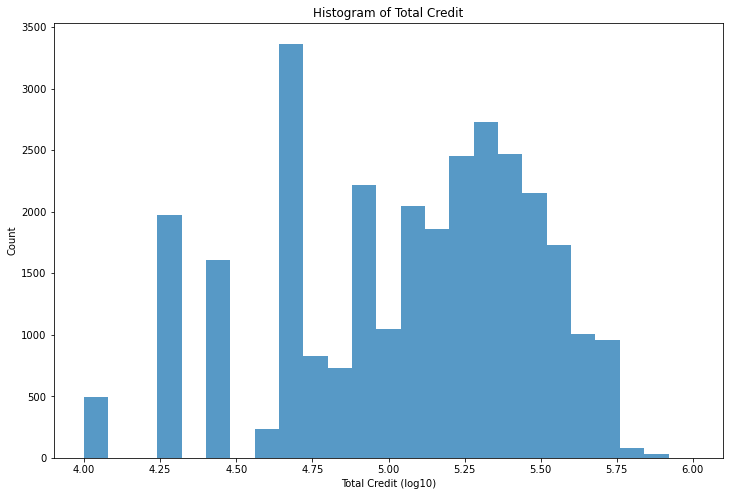

In [15]:
plt.hist(np.log10(df['limit_bal']), 25, alpha=0.75)
plt.xlabel('Total Credit (log10)')
plt.ylabel('Count')
plt.title('Histogram of Total Credit')
plt.show()

#### Looking at age

The histogram shows that most customers are between the ages of 20 and 45. The distribution tails off to older ages.
The average default rate plot does not show much variation with different ages. The large swings in ages over 55 are likely due to the fact that we do not have many customers over 55 in our dataset.

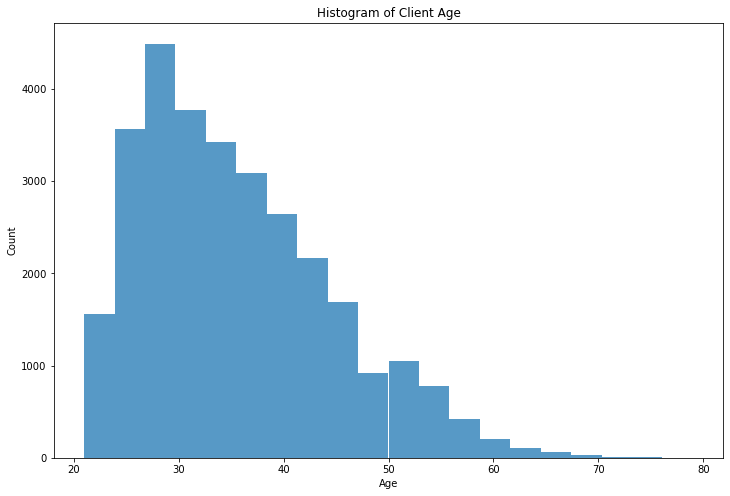

In [16]:
plt.hist(df['age'], 20, alpha=0.75)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Client Age')
plt.show()

In [17]:
df_age = pd.DataFrame(high_level_stats_cat(df, ['age']).sort_values('age', ascending=False))

plt.plot(df_age['age'],df_age['default_rate'])
plt.title('Average Default Rate by Age')
plt.xlabel('Age')
plt.ylabel('Average Default Rate')
plt.show()

NameError: name 'high_level_stats_factor' is not defined

#### Looking at the pay variables
From the data dictionary: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: pay_0 the repayment status in September, 2005; pay_2 = the repayment status in August, 2005; . . .;pay_6 = the repayment status in April, 2005. 
The measurement scale for the repayment status is: 
- -1 = pay duly
- 1 = payment delay for one month
- 2 = payment delay for two months 
- . . . 
- 8 = payment delay for eight months
- 9 = payment delay for nine months and above.

Many customers have months with status -2, which is strange since it is not a status in the data dictionary. Looking more closely at individual examples in the data, it seems like -2 represents months where no payment was made and the bill amount was 0.

Although these variables are factors, since they are ordinal, we could keep them as numerical.

One interesting thing to see is that the previous month seems to be more correlated with the coming month. This is interesting for our model since it means that pay_0 could be the most useful of these variables at predicting the if the client would default in the coming month.

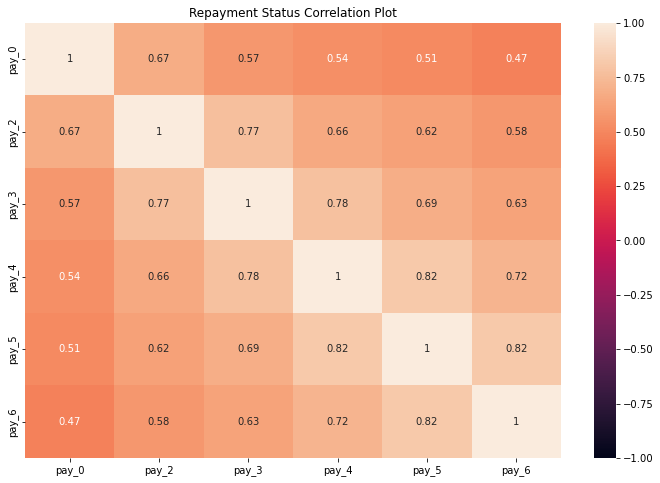

In [18]:
df_pay_corr = df[['pay_0','pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].corr()

plt.title('Repayment Status Correlation Plot')
sns.heatmap(df_pay_corr, 
            xticklabels=df_pay_corr.columns.values,
            yticklabels=df_pay_corr.columns.values,
            vmin=-1,
            vmax=1,
            annot=True)
plt.show()

#### Looking at the bill amount variables
From the data dictionary: Amount of bill statement (NT dollar). bill_amt1 = amount of bill statement in September, 2005; bill_amt2 = amount of bill statement in August, 2005; . . .; bill_amt6 = amount of bill statement in April, 2005.

Similarly to the payment status variables, adjacent months tend to be more correlated to one another.

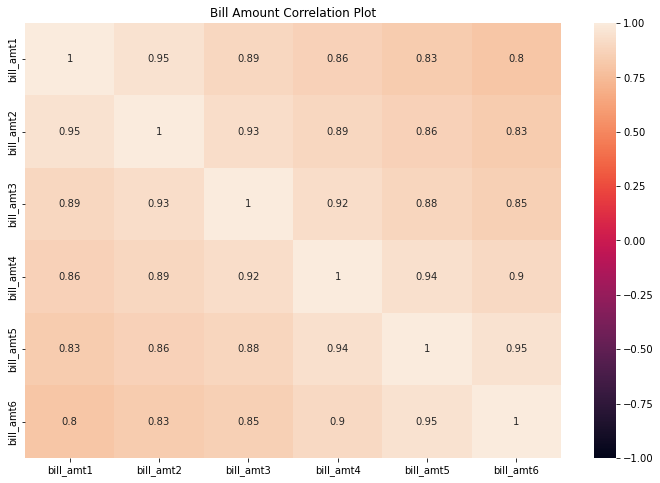

In [19]:
df_bill_amt_corr = df[['bill_amt1','bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']].corr()

plt.title('Bill Amount Correlation Plot')
sns.heatmap(df_bill_amt_corr, 
            xticklabels=df_bill_amt_corr.columns.values,
            yticklabels=df_bill_amt_corr.columns.values,
            vmin=-1,
            vmax=1,
            annot=True)
plt.show()

#### Looking at the pay_amt variables
From the data dictionary: Amount of previous payment (NT dollar). pay_amt1 = amount paid in September, 2005; pay_amt2 = amount paid in August, 2005; . . .;pay_amt6 = amount paid in April, 2005.

Interestingly, it seems like there is no correlation between the amounts paid in different months. This is interesting since the bill amounts seemed a lot more correlated, which means that many people are not paying their bills each month systematically.

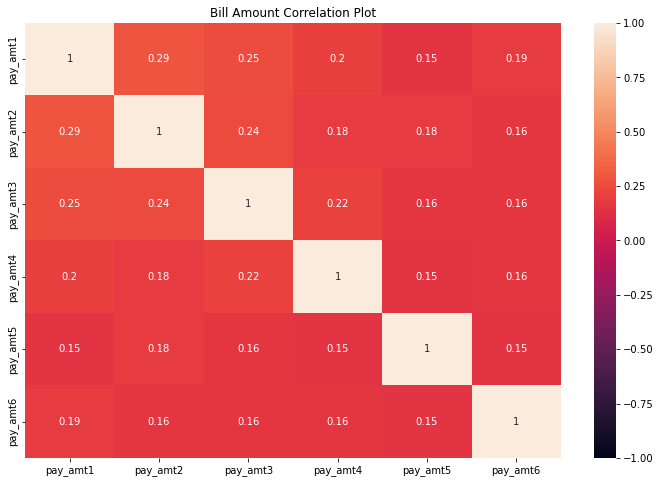

In [20]:
df_pay_amt_corr = df[['pay_amt1','pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']].corr()

plt.title('Bill Amount Correlation Plot')
sns.heatmap(df_pay_amt_corr, 
            xticklabels=df_pay_amt_corr.columns.values,
            yticklabels=df_pay_amt_corr.columns.values,
            vmin=-1,
            vmax=1,
            annot=True)
plt.show()

## Data Preprocessing
#### Categorical features
1. Creating a function that removes unwanted levels in categorical features.
2. Applying said function to education since it has 3 levels that I believe should be in "other".
3. Creating the transformer which only does one hot encoding

In [21]:
def set_level_to_target(pd_df: pd.DataFrame, colname: str, remove_levels: list, target_level)->pd.DataFrame:
    """Takes a categorical variable and sets the levels to remove equal to the target level."""
    pd_df[colname] = np.where(np.isin(pd_df[colname], remove_levels), target_level, pd_df[colname])
    return pd_df

In [22]:
df = set_level_to_target(df, 'education',[0,5,6],4)

In [23]:
CATEGORICAL_FEATURES = ['sex', 'education', 'marriage']
categorical_transformer = OneHotEncoder()

#### Numerical features
1. The first step is to take the log10 of the available credit (limit_bal). This is done since the data is heavily right tailed and the transformation will help the feature look more like it is normally distributed. Also, unlike many of the other numerical variables in the dataset, it can receive the transfromation (0>limit_bal>infinity).
2. The second step is the standard scaler, which centers the mean to 0 and changes the standard deviation to 1.

In [24]:
df['limit_bal'] = np.log10(df['limit_bal'])

In [25]:
NUMERIC_FEATURES = ['limit_bal',
                    'age',
                    'pay_0',
                    'pay_2',
                    'pay_3',
                    'pay_4',
                    'pay_5',
                    'pay_6',
                    'bill_amt1',
                    'bill_amt2',
                    'bill_amt3',
                    'bill_amt4',
                    'bill_amt5',
                    'bill_amt6',
                    'pay_amt1',
                    'pay_amt2',
                    'pay_amt3',
                    'pay_amt4',
                    'pay_amt5',
                    'pay_amt6']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

#### Final preprocessor
Finally, we can create our preprocessor using the two transformers we have built in the previous steps.

In [26]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, NUMERIC_FEATURES),
                                               ('cat', categorical_transformer, CATEGORICAL_FEATURES)])

#### Splitting the dataset
The dataset is split between the train and test set with an 80%-20% split. We keep 20% of the observation to evaluate how the models perform on observations it has not seen.

In [27]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True)

X_train = df_train[CATEGORICAL_FEATURES + NUMERIC_FEATURES]
X_test = df_test[CATEGORICAL_FEATURES + NUMERIC_FEATURES]

y_train = df_train[TARGET]
y_test = df_test[TARGET]

## Modelling
Since we are mainly interested in probabilities and not the actual classification, we must choose the metric appropriately. Log loss is a good choice since it does not depend on a probability threshold like sensitivity and specificity do for example. Therefore, we will be using log loss to measure our models. Remember that a lower log loss is better.
#### Logistic regression
Let's start with a logistic regression model as our base model so we can see how much we can improve with more complex models.

In [28]:
log = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000))])

log.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['limit_bal', 'age', 'pay_0',
                                                   'pay_2', 'pay_3', 'pay_4',
                                                   'pay_5', 'pay_6',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
                                                   'pay_amt5', 'pay_amt6']),
                                                 ('cat', One

In [29]:
log_pred = log.predict_proba(X_test)

log_train_loss = log_loss(y_train, log.predict_proba(X_train))
log_test_loss = log_loss(y_test, log_pred)

print('Training Loss: {}\n'\
       'Test Loss:     {}'.format(log_train_loss, log_test_loss))

Training Loss: 0.46161509300628467
Test Loss:     0.47187017641789786


The logistic model did not overfit since it has a test loss that is similar to its training loss. This model will serve as our baseline.

#### Random forest classifier
Let's now look at a random forest classifier. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

For the next models, we will do cross validation using 5 folds and do a bit of hyperparameter tuning using random grid search in order to improve our models' performance.

In [30]:
rfc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

grid_param = {
    'classifier__n_estimators': [1000, 1200, 1500],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [15, 18, 21],
    'classifier__min_impurity_decrease': [0.001, 0.005, 0.1],
    'classifier__criterion': ['gini']
}

rfc_gd = RandomizedSearchCV(estimator=rfc,
                            param_distributions=grid_param,
                            n_iter=10,
                            scoring='neg_log_loss',
                            cv=FOLDS,
                            n_jobs=-1)

rfc_gd.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'pay_0',
                                                                                'pay_2',
                                                                                'pay_3',
                                                                                'pay_4',
                                                                    

In [31]:
rfc_gd.best_params_

{'classifier__n_estimators': 1000,
 'classifier__min_impurity_decrease': 0.001,
 'classifier__max_depth': 21,
 'classifier__criterion': 'gini',
 'classifier__bootstrap': True}

In [32]:
rfc_pred = rfc_gd.predict_proba(X_test)

rfc_train_loss = log_loss(y_train, rfc_gd.predict_proba(X_train))
rfc_test_loss = log_loss(y_test, rfc_pred)

print('Training Loss: {}\n'\
       'Test Loss:     {}'.format(rfc_train_loss, rfc_test_loss)) 

Training Loss: 0.4401864218226277
Test Loss:     0.45198212051836867


With some random grid search, we were able to find a random forest model that performed better than the base logistic model. This model is our best one so far, but there are some concerns since the model seems to have been overfitting the training set.

#### K Nearest Neighbor (KNN)
KNN uses the K nearest neighbors to make the prediction. We are using distance weights to allow for the probability to be more granular since we mostly care about the precision of the probability.

In [33]:
knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

grid_param = {
    'classifier__n_neighbors': [5, 10, 15],
    'classifier__p': [1, 2, 3, 4],
    'classifier__weights': ['distance']
}

knn_gd = RandomizedSearchCV(estimator=knn,
                            param_distributions=grid_param,
                            n_iter=10,
                            scoring='neg_log_loss',
                            cv=FOLDS,
                            n_jobs=-1)

knn_gd.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'pay_0',
                                                                                'pay_2',
                                                                                'pay_3',
                                                                                'pay_4',
                                                                    

In [34]:
knn_gd.best_params_

{'classifier__weights': 'distance',
 'classifier__p': 1,
 'classifier__n_neighbors': 15}

In [35]:
knn_pred = knn_gd.predict_proba(X_test)

knn_train_loss = log_loss(y_train, knn_gd.predict_proba(X_train))
knn_test_loss = log_loss(y_test, knn_pred)

print('Training Loss: {}\n'\
       'Test Loss:     {}'.format(knn_train_loss, knn_test_loss))

Training Loss: 0.0008522757226346465
Test Loss:     0.9086144350275155


This model is very bad since it is overfitting badly on the training set and performs very badly on the test set. We should consider another algorithm instead of KNN.

#### XGBoost
Now, let's try XGBoost. XGBoost is a tree based algorithm that introduces boosting. The basic idea behind boosting algorithms is building a weak model, making conclusions about the various feature importance and parameters, and then using those conclusions to build a new, stronger model and capitalize on the misclassification error of the previous model and try to reduce it.

In [36]:
xgc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier())])

grid_param = {
    'classifier__learning_rate': [ 0.05, 0.1],
    'classifier__min_split_loss': [0.1, 0.2, 0.3],
    'classifier__max_depth': [6, 8],
    'classifier__min_child_weight': [3, 4]
}

xgc_gd = RandomizedSearchCV(estimator=xgc,
                            param_distributions=grid_param,
                            n_iter=10,
                            scoring='neg_log_loss',
                            cv=FOLDS,
                            n_jobs=-1)

xgc_gd.fit(X_train, y_train)

C:\Users\Felix Trepanier\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:15:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'pay_0',
                                                                                'pay_2',
                                                                                'pay_3',
                                                                                'pay_4',
                                                                    

In [37]:
xgc_gd.best_params_

{'classifier__min_split_loss': 0.2,
 'classifier__min_child_weight': 3,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.05}

In [38]:
xgc_pred = xgc_gd.predict_proba(X_test)

xgc_train_loss = log_loss(y_train, xgc_gd.predict_proba(X_train))
xgc_test_loss = log_loss(y_test, xgc_pred)

print('Training Loss: {}\n'\
       'Test Loss:     {}'.format(xgc_train_loss, xgc_test_loss))

Training Loss: 0.3866541002748224
Test Loss:     0.4346499006813392


So far, XGBoost is our best model with a test loss of 0.4346 There is a bit of overfitting on the training set, as examplified by the fact that training loss is lower at 0.3866. It had the following hyperparameters:
- min_split_loss: 0.2
- min_child_weight: 3
- max_depth: 6
- learning_rate: 0.05

#### SGD
This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). The data should have zero mean and unit variance.

In [39]:
sgd = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier())])

grid_param = {
    'classifier__loss': ['hinge','log','modified_huber'],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__alpha': [0.001, 0.005, 0.01, 0.05]
}

sgd_gd = RandomizedSearchCV(estimator=sgd,
                            param_distributions=grid_param,
                            n_iter=10,
                            scoring='neg_log_loss',
                            cv=FOLDS,
                            n_jobs=-1)

sgd_gd.fit(X_train, y_train)

C:\Users\Felix Trepanier\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan -0.90650065         nan -0.78532427 -0.91558725         nan
         nan -0.82732332 -0.86325707 -0.46820064]
  category=UserWarning


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'pay_0',
                                                                                'pay_2',
                                                                                'pay_3',
                                                                                'pay_4',
                                                                    

In [40]:
sgd_gd.best_params_

{'classifier__penalty': 'l1',
 'classifier__loss': 'log',
 'classifier__alpha': 0.01}

In [41]:
sgd_pred = sgd_gd.predict_proba(X_test)

sgd_train_loss = log_loss(y_train, sgd_gd.predict_proba(X_train))
sgd_test_loss = log_loss(y_test, sgd_pred)

print('Training Loss: {}\n'\
       'Test Loss:     {}'.format(sgd_train_loss, sgd_test_loss))

Training Loss: 0.4674157085797733
Test Loss:     0.478394993630265


Training loss and test loss are around the same, which tells us that there is no overfitting. The problem is that loss is higher than our base logistic model. Therefore, we will not select this model since it does not perform well on this data.

#### Ada Boost
An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [42]:
ada = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', AdaBoostClassifier())])

grid_param = {
    'classifier__n_estimators': [10, 25, 50, 100],
    'classifier__learning_rate': [0.001, 0.005, 0.01]
}

ada_gd = RandomizedSearchCV(estimator=ada,
                            param_distributions=grid_param,
                            n_iter=10,
                            scoring='neg_log_loss',
                            cv=FOLDS,
                            n_jobs=-1)

ada_gd.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['limit_bal',
                                                                                'age',
                                                                                'pay_0',
                                                                                'pay_2',
                                                                                'pay_3',
                                                                                'pay_4',
                                                                    

In [43]:
ada_gd.best_params_

{'classifier__n_estimators': 50, 'classifier__learning_rate': 0.005}

In [44]:
ada_pred = ada_gd.predict_proba(X_test)

ada_train_loss = log_loss(y_train, ada_gd.predict_proba(X_train))
ada_test_loss = log_loss(y_test, ada_pred)

print('Training Loss: {}\n'\
       'Test Loss:     {}'.format(ada_train_loss, ada_test_loss))

Training Loss: 0.4584585644377304
Test Loss:     0.4719895399120798


ADABooster performed similarly to SGD with very close training and test loss. Test loss is higher than 

#### Selecting a model
Of the 6 models we have built so far, our XGBoost model is the one that has performed the best so far since it has the lowest log loss and the overfitting concerns are not too big. When we look at the feature importance plot, we can see that bill amounts in recent months, total credit (limit_bal), payment amounts in recent months, and age seem to be the most important features in our model. Interestingly, the payment statuses in recent months do not seem to be very important. This could be related to how the data was formated and would be a potential way to improve on this model.

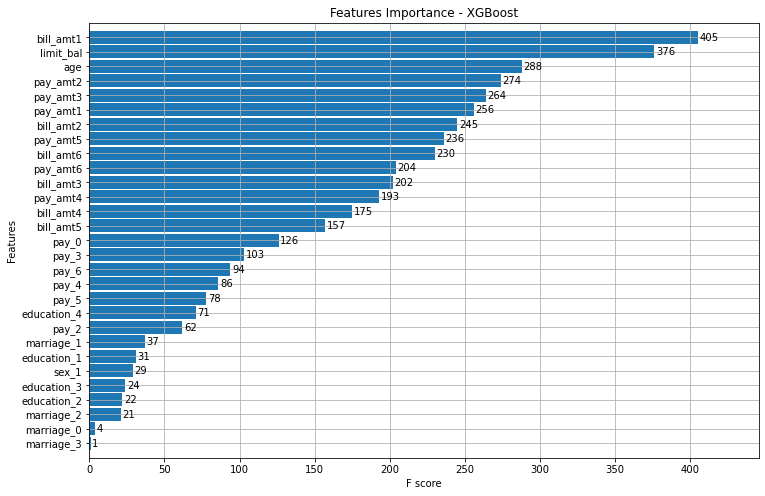

In [45]:
ENC_CATEGORICAL_FEATURES = xgc_gd.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names(CATEGORICAL_FEATURES).tolist()

xgc_gd_copy = xgc_gd
xgc_gd_copy.best_estimator_.named_steps['classifier'].get_booster().feature_names = NUMERIC_FEATURES + ENC_CATEGORICAL_FEATURES

xgb.plot_importance(xgc_gd_copy.best_estimator_.named_steps['classifier'],
                    height=0.9,
                    title="Features Importance - XGBoost")
plt.show()

## Conclusion
We started this project by doing an exploratory data analysis. This analysis helped us improve our understanding of the dataset and see that some categorical variables had levels that were not present in the data dictionary.

We then built data transfomers (one for categorical features and the other for numerical features) to preprocess the dataset and get it ready for model building.

During the model building phase we tested the following models:
- A logistic regression to serve as our base model. It performed reasonably well with a test loss of 0.4718.
- Random Forest, which beat the base model with a resulting test loss of 0.4416.
- KNN, which was very bad with a test log loss of 0.9086
- XGBoost, which ended up being our best model with a test loss of 0.4346.
- SGD with a resulting test loss of 0.4725.
- ADABoost with a resulting test loss of 0.4720.

Finally, since XGBoost was our top performing model in the model building phase, we selected this algorithm to build our final model.

#### Potential improvements
- Figure out what the missing labels mean.
- Split the payment status variables into numerical for ones that have a month (value >= 0), and dummies for the other levels.
- Test more algorithms.
- Try deep learning (Keras).
- Do more hyperparameter tuning.
- Class weights could be used since the target variable only represent ~22% of cases.
- Looking at individual observations, it seems like mortgage were included in this dataset. I would consider splitting the two since there is a good chance that mortgage repayment and credit card repayment do not behave in the same way.

#### How could this model be used by Credit Sesame
Since Credit Sesame offers credit cards, this model could be used to predict monthly revenue from credit card repayment. Indeed, the probability prediction of this model can be multiplied with the amount owed for the next month to give the overall expected revenue from credit cards. The amount owed next month could also be predicted by another model. With these two models, it could then be possible to look further into the future and see how much revenue Credit Sesame could expect to get. In the end, the company would likely have a better understanding of its future cashflow and could therefore plan accordingly.

Another way this model could be used by Credit Sesame would be to send alerts to clients the model believes are now likelier to miss a payment to remind them to pay their bill on time. Customers who are trying to improve their credit scores could benefit from this since they would have a reminder to pay their balance on time. This may not necessarily be in the best interest of the company since interest is usually accrued on late payments.